In [1]:
import pandas as pd
import numpy as np

COE Bidding Result Prices dataset from data.gov.sg
https://data.gov.sg/datasets/d_69b3380ad7e51aff3a7dcc84eba52b8a/view

In [2]:
# load the data
data = pd.read_csv("COEBiddingResultsPrices.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   month          1870 non-null   object
 1   bidding_no     1870 non-null   int64 
 2   vehicle_class  1870 non-null   object
 3   quota          1870 non-null   int64 
 4   bids_success   1870 non-null   object
 5   bids_received  1870 non-null   object
 6   premium        1870 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 102.4+ KB


Since most of the values are objects, we need to filter them out and convert them into numeric. This helps us to better format the data.

In [3]:
# Filtering text by removing commas (if any)
data['bids_received'] = data['bids_received'].str.replace(',', '')
data['bids_success'] = data['bids_success'].str.replace(',', '')

In [4]:
# converting the values from object into numeric
data['bids_received'] = pd.to_numeric(data['bids_received'])
data['bids_success'] = pd.to_numeric(data['bids_success'])

In [5]:
# sanity check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   month          1870 non-null   object
 1   bidding_no     1870 non-null   int64 
 2   vehicle_class  1870 non-null   object
 3   quota          1870 non-null   int64 
 4   bids_success   1870 non-null   int64 
 5   bids_received  1870 non-null   int64 
 6   premium        1870 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 102.4+ KB


Perfect. Now, I noticed that there is a bidding_no = {1, 2} where it represents the bidding rounds during every COE auction. It is well known that the two rounds of COE auction happens during the first Monday and subsequently on the third Monday of the month. To keep this simple, I will indicate it as the first day and the start of the third week -- meaning 1st and 15th of the month.

In [6]:
# mapping bidding_no to day of month
data['day'] = data['bidding_no'].map({1: 1, 2: 15})
data['date'] = data['month'].astype(str) + '-' + data['day'].astype(str)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# need to set this as index for our data
data = data.set_index('date')

# sanity check again
data

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium,day
date,,,,,,,,
2010-01-01,2010-01,1,Category A,1152,1145,1342,18502,1
2010-01-01,2010-01,1,Category B,687,679,883,19190,1
2010-01-01,2010-01,1,Category C,173,173,265,19001,1
2010-01-01,2010-01,1,Category D,373,365,509,889,1
2010-01-01,2010-01,1,Category E,586,567,1011,19889,1
...,...,...,...,...,...,...,...,...
2025-10-15,2025-10,2,Category A,1270,1262,1968,122000,15
2025-10-15,2025-10,2,Category B,809,800,977,131889,15
2025-10-15,2025-10,2,Category C,276,276,427,76801,15


In [7]:
# check for null values
data.count().isnull()

month            False
bidding_no       False
vehicle_class    False
quota            False
bids_success     False
bids_received    False
premium          False
day              False
dtype: bool

In [8]:
#check for na values
data.count().isna()

month            False
bidding_no       False
vehicle_class    False
quota            False
bids_success     False
bids_received    False
premium          False
day              False
dtype: bool

Since we have roughly tidied up our dataset, we can now sieve visual observations from it. We'll start by looking at the distribution of the premium prices, which is what we are targeting. Perhaps we can see if it can be modelled against a specific distribution.

In [9]:
# filter out by categories
cat_a = data[data['vehicle_class'] == "Category A"].copy()
cat_b = data[data['vehicle_class'] == "Category B"].copy()
cat_c = data[data['vehicle_class'] == "Category C"].copy()
cat_d = data[data['vehicle_class'] == "Category D"].copy()
cat_e = data[data['vehicle_class'] == "Category E"].copy()

# finding percentage change of premium for each categories
cat_a['% Change'] = cat_a['premium'].pct_change() * 100
cat_b['% Change'] = cat_b['premium'].pct_change() * 100
cat_c['% Change'] = cat_c['premium'].pct_change() * 100
cat_d['% Change'] = cat_d['premium'].pct_change() * 100
cat_e['% Change'] = cat_e['premium'].pct_change() * 100


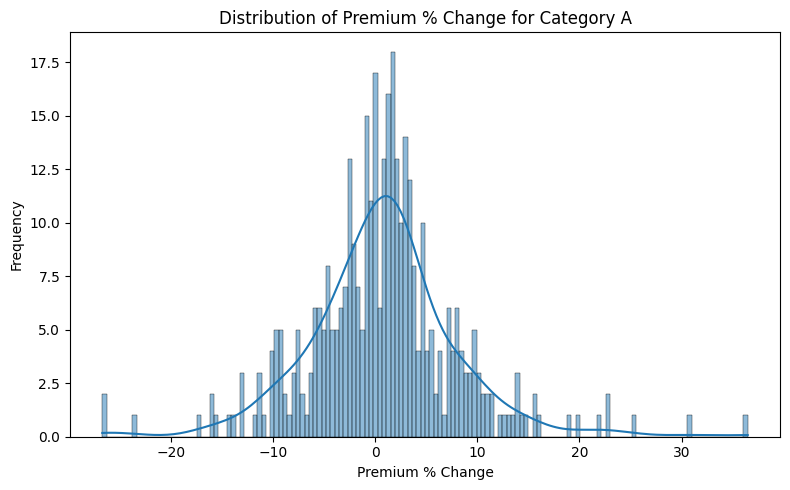

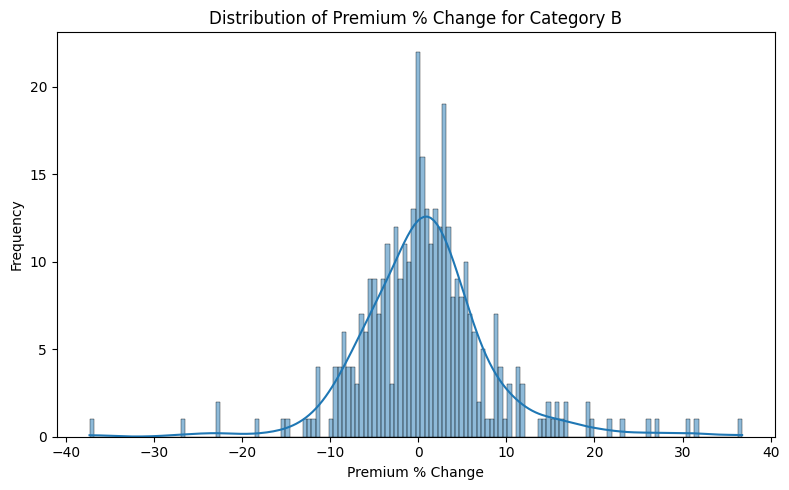

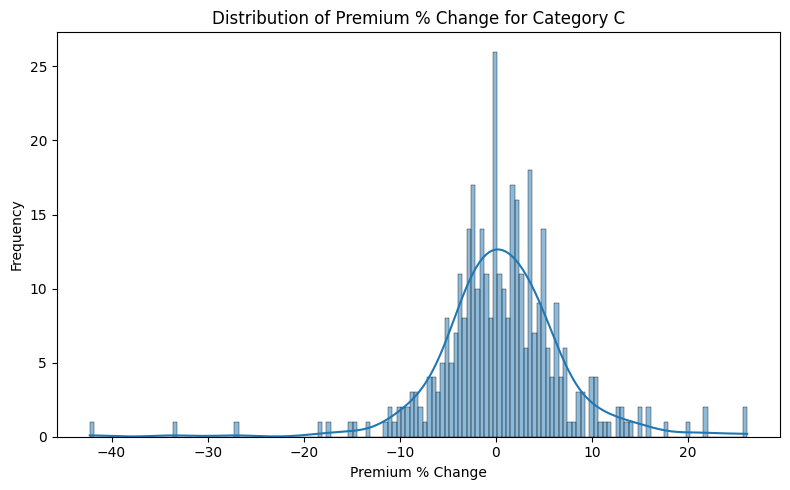

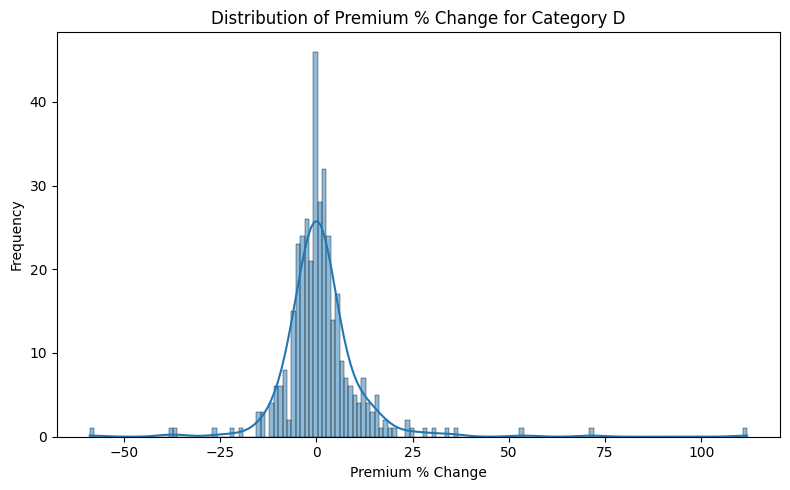

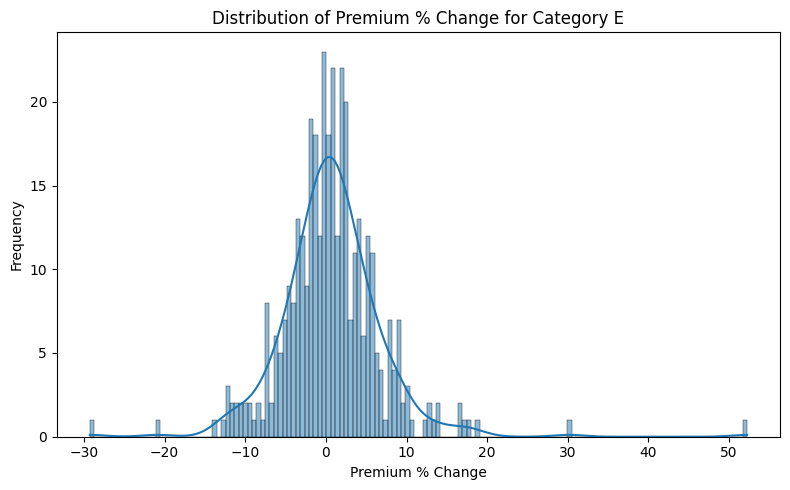

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

categories = [
        (cat_a['% Change'], 'Category A'),
        (cat_b['% Change'], 'Category B'),
        (cat_c['% Change'], 'Category C'),
        (cat_d['% Change'], 'Category D'),
        (cat_e['% Change'], 'Category E')
    ]

# plotting the percentage change in premium prices to view its ditribution
for data_series, category_name in categories:
    plt.figure(figsize=(8, 5)) 
    sns.histplot(data_series.dropna(), kde=True, bins=150)
    plt.title(f'Distribution of Premium % Change for {category_name}')
    plt.xlabel('Premium % Change')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

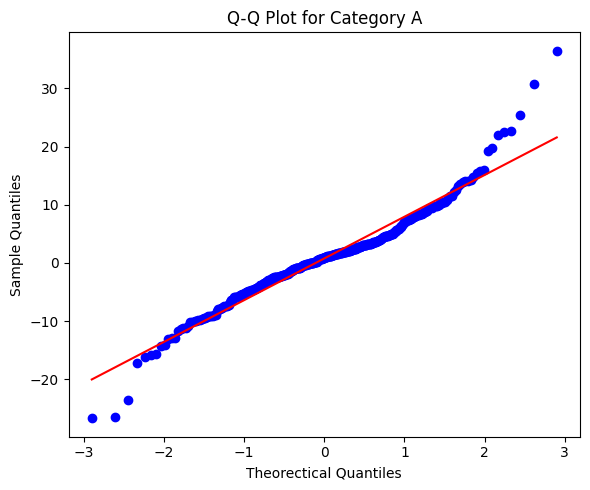

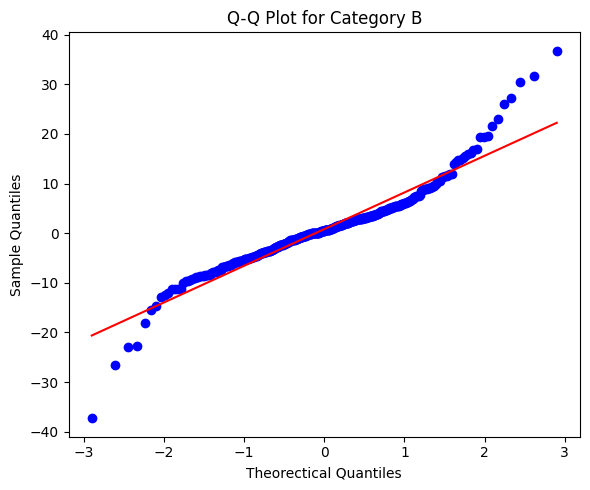

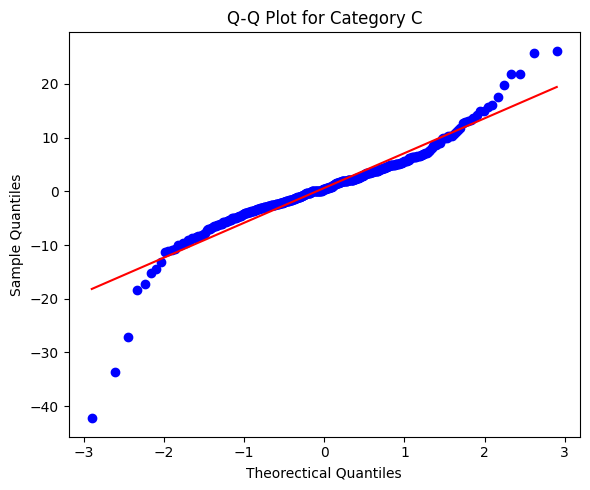

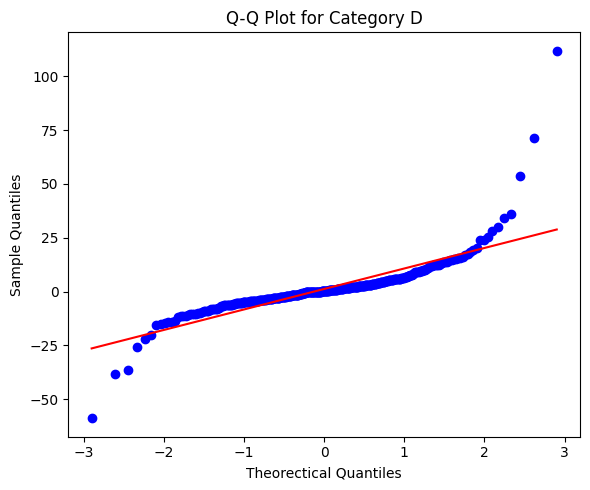

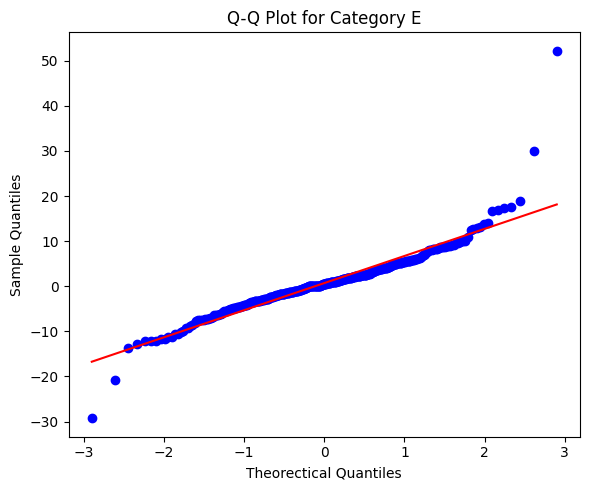

In [11]:
# plotting the percentage change in premium prices via a Q-Q plot to determine its normality
# using the same data mapped i.e "categories"

for data_series, category_name in categories:
    plt.figure(figsize=(6,5))
    stats.probplot(data_series.dropna(), dist='norm', plot=plt)
    plt.title(f"Q-Q Plot for {category_name}")
    plt.xlabel("Theorectical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.tight_layout()
    plt.show()

Given the results of the Q-Q plots, we can see that the premium prices have heavy tails, indicating that they do not conservatively follow the normal distribution. This will affect our use of Linear Regression models as well as other statistical tests to be carried out such as p-values and confidence intervals. To deal with this, we can 1) adjust the dataset to fit the distribution for appropriate use 2) use other machine learning models for premium price prediction. 

In [12]:
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [13]:
# adjusting the dataset
"""
we adjust the dataset by using one-hot encoding for the vehicle class category and using the log of premium prices. This will hopefully allow us to acheive a log-normal distribution of oremium prices.
"""
X, y = data.drop(['premium', 'month', 'bidding_no', 'day'], axis=1), data['premium']
X_encoded = pd.get_dummies(X, columns=['vehicle_class'])
y_log = np.log1p(y)
print(X_encoded, y_log)

            quota  bids_success  bids_received  vehicle_class_Category A  \
date                                                                       
2010-01-01   1152          1145           1342                      True   
2010-01-01    687           679            883                     False   
2010-01-01    173           173            265                     False   
2010-01-01    373           365            509                     False   
2010-01-01    586           567           1011                     False   
...           ...           ...            ...                       ...   
2025-10-15   1270          1262           1968                      True   
2025-10-15    809           800            977                     False   
2025-10-15    276           276            427                     False   
2025-10-15    533           528            598                     False   
2025-10-15    261           260            414                     False   

           

In [14]:
X_train, X_test, y_log_train, y_log_test = train_test_split(X_encoded, y_log, test_size=0.2, random_state=42)
X_train.head()

,quota,bids_success,bids_received,vehicle_class_Category A,vehicle_class_Category B,vehicle_class_Category C,vehicle_class_Category D,vehicle_class_Category E
date,,,,,,,,
2023-01-15,149,147,248,False,False,False,False,True
2012-01-01,344,341,530,False,False,False,False,True
2019-07-15,1143,1140,1677,False,True,False,False,False
2020-08-15,357,356,586,False,False,True,False,False
2016-01-01,1027,1019,1262,False,True,False,False,False


# Anomaly anlaysis based on model residuals 

In [15]:
from sklearn.linear_model import LinearRegression

# Linear regression model for premium prices
model_lr = LinearRegression().fit(X_train, y_log_train)
model_lr_test_score = model_lr.score(X_test, y_log_test)
model_lr_log_pred_score = model_lr.predict(X_test)
model_lr_pred_score, y_test = np.expm1(model_lr_log_pred_score), np.expm1(y_log_test)
residuals = model_lr_pred_score - y_test
print(f'R-squared for test scores: {model_lr_test_score}')
print(f'Loss fuction: {residuals}')

R-squared for test scores: 0.8501960383501275
Loss fuction: date
2024-06-01   -34206.911529
2022-08-15   -41294.018222
2017-09-01     1485.058064
2012-04-15     1203.073804
2013-06-15     -658.464537
                  ...     
2013-08-15   -11292.948654
2025-04-15   -21028.664635
2013-02-01   -27132.914274
2012-04-01    -6026.983052
2011-07-01    -5503.521182
Name: premium, Length: 374, dtype: float64


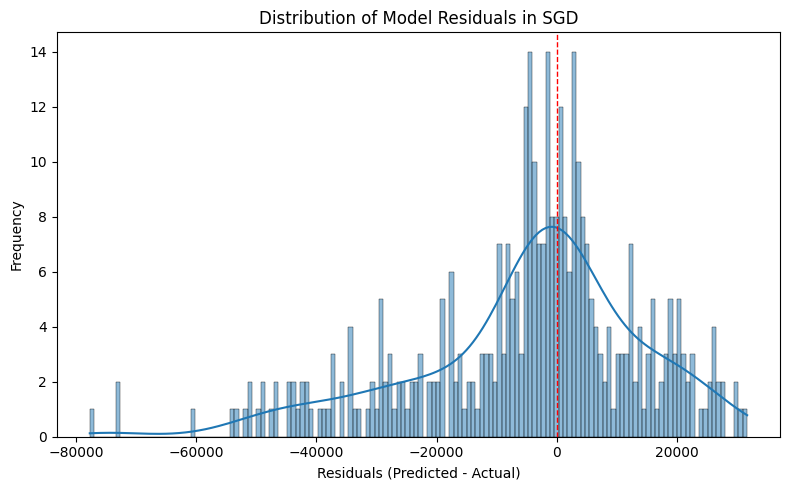

In [16]:
# plotting model residuals
plt.figure(figsize=(8, 5)) 
sns.histplot(residuals.dropna(), kde=True, bins=150)
plt.title('Distribution of Model Residuals in SGD')
plt.xlabel('Residuals (Predicted - Actual)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

Based on the distribution of residuals (predicted premiums - actual premiums), we see the bulk of our model's errors clustered near $0 -- indicating signs of unbiasness and predicted premiums close to the actual premiums.

In [17]:
residuals

date
2024-06-01   -34206.911529
2022-08-15   -41294.018222
2017-09-01     1485.058064
2012-04-15     1203.073804
2013-06-15     -658.464537
                  ...     
2013-08-15   -11292.948654
2025-04-15   -21028.664635
2013-02-01   -27132.914274
2012-04-01    -6026.983052
2011-07-01    -5503.521182
Name: premium, Length: 374, dtype: float64

In [18]:
# gathering parameters of the residual datapoints
r_df = pd.DataFrame(residuals, index=residuals.index)
r_df = r_df.reset_index()
r_miu = r_df['premium'].mean()
r_std = r_df['premium'].std()
r_upper_threshold = r_miu + (2 * r_std)
r_lower_threshold = r_miu - (2 * r_std)
r_anomalies = r_df[(r_df['premium'] >= r_upper_threshold) | (r_df['premium'] <= r_lower_threshold )]
r_miu, r_std, r_anomalies
print(f'Residual Mean: {r_miu}\nResidual Standard Deviation: {r_std}\nUpper residual anomaly threshold (2 std): {r_upper_threshold}\nLower residual anomaly threshold (2 std): {r_lower_threshold}\nNumber of anomalies: {len(r_anomalies)}')

Residual Mean: -5011.4864340587355
Residual Standard Deviation: 19208.2576341036
Upper residual anomaly threshold (2 std): 33405.02883414846
Lower residual anomaly threshold (2 std): -43428.00170226594
Number of anomalies: 19


In [22]:
print(f'Residual anomaly hitlist:\n{r_anomalies}')

Residual anomaly hitlist:
          date       premium
32  2025-03-01 -48574.860989
37  2025-10-01 -77758.417420
57  2023-10-01 -43607.181175
115 2023-09-15 -73369.104858
124 2023-05-01 -51263.535576
153 2025-05-01 -53471.112371
170 2025-04-01 -46876.500371
205 2025-07-15 -51572.817376
226 2023-05-01 -43796.970087
228 2025-04-15 -47805.699640
236 2023-04-01 -46738.693002
265 2025-03-15 -51199.596864
268 2025-06-01 -48643.246216
280 2025-01-15 -44655.628142
287 2023-08-01 -54204.977674
315 2025-09-15 -73311.283204
331 2024-10-15 -49456.672242
354 2025-08-15 -60320.956779
364 2025-06-01 -44240.864641


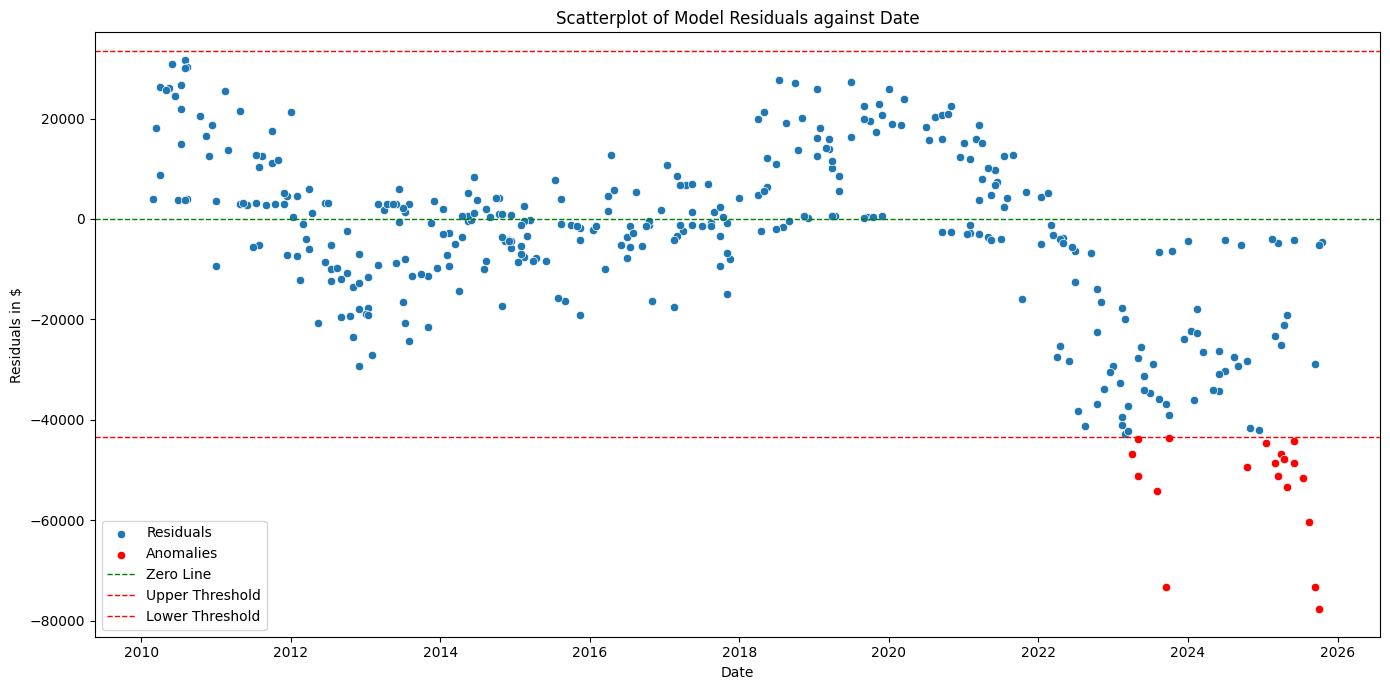

In [46]:
# scatterplot of residuals on time with boundary of 2 std
plt.figure(figsize=(14,7))

# scatterplot of residuals first
sns.scatterplot(x='date', 
                y='premium', 
                data=r_df, 
                #color='grey',
                label='Residuals')

# scatterplot of anomalies overlay
sns.scatterplot(x='date',
                y='premium',
                data=r_anomalies,
                color='red',
                label='Anomalies')

# adding lines
plt.axhline(y=0, color='green', linestyle='--', linewidth=1, label='Zero Line') # zero line
plt.axhline(y=r_upper_threshold, color='red', linestyle='--', linewidth=1, label='Upper Threshold') # upper threshold line
plt.axhline(y=r_lower_threshold, color='red', linestyle='--', linewidth=1, label='Lower Threshold') # lower threshold line

# plt axis and title
plt.xlabel("Date")
plt.ylabel("Residuals in $")
plt.title("Scatterplot of Model Residuals against Date")
plt.legend()
plt.tight_layout()
plt.show()

Based on the scatterplot of residuals against bidding dates, we see that our residual datapoints are scattered randomly around the zero line (y=0). This reiterates our model's unbiasness and the state of the market volatility -- random at best and inconsistent. Datapoints below the zero line indicates higher actual premiums as compared to predicted premiums -- also known as a positive price shock -- and datapoints above the zero line indicates lower actual premiums as compared to predicted premiums -- also known as a negative price shock. We also note the explosive datapoints after 2020, seemingly a positive price shock after COVID-19. This could be due to several reasons, such as post COVID-19 economic recovery, pent-up demand after the Circuit Breaker or incoming EV car models into the industry at subsized rates. We'll investigate this further and try to account for the discrepancies.

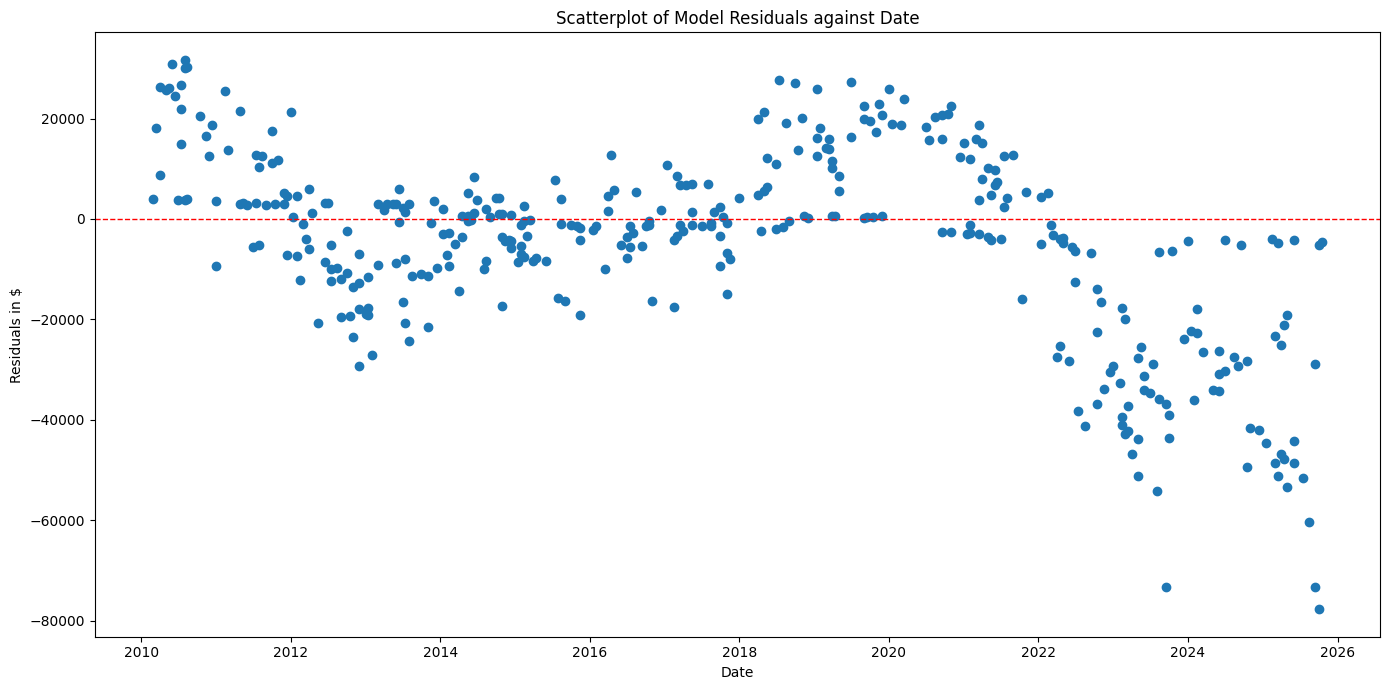

In [20]:
# scatterplot of residuals on time
plt.figure(figsize=(14,7))
plt.scatter(residuals.index, residuals)
plt.xlabel("Date")
plt.ylabel("Residuals in $")
plt.title("Scatterplot of Model Residuals against Date")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()